In [2]:
%matplotlib inline
import os

from glob import glob

import numpy as np
import xarray as xr


## read some CESM-LE data

In [8]:
cesmle_root = '/glade/p/cesm/community/CESM-LE/data/CESM-CAM5-BGC-LE'

component = 'ocn'
freq = 'monthly'
stream = 'pop.h' # POP ocean model monthly stream
case = 'b.e11.B20TRC5CNBDRD.f09_g16.001'

variable = ['SST', 'diatChl']

# loop over variables, construct list of datasets
ds_list = []
for v in variable:
    files = glob(f'{cesmle_root}/{component}/proc/tseries/{freq}/{v}/{case}.{stream}.{v}.*.nc')
    dsi = xr.open_mfdataset(files, decode_coords=False)
    ds_list.append(dsi)

ds = xr.merge(ds_list)
ds

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 1872, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * z_t                   (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                 (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * time                  (time) object 1850-02-01 00:00:00 ... 2006-01-01 00:00:00
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top               (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    ANGLE                 (nlat, 

## visualize land mask

`KMT` is the `k` index of the models lowest level. We can use this variable to visualize the land mask.

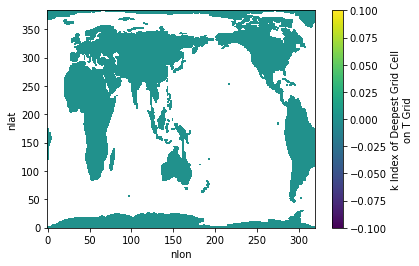

In [13]:
ds.KMT.where(ds.KMT==0).plot()

## take a peak at SST variable

In [20]:
ds.SST

<xarray.DataArray 'SST' (time: 1872, z_t: 1, nlat: 384, nlon: 320)>
dask.array<shape=(1872, 1, 384, 320), dtype=float32, chunksize=(1872, 1, 384, 320)>
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2006-01-01 00:00:00
  * z_t      (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    coordinates:   TLONG TLAT z_t time
    grid_loc:      3111
    cell_methods:  time: mean

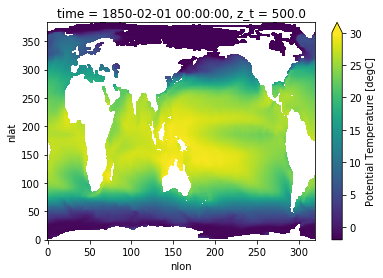

In [26]:
ds.SST.isel(time=0).plot(vmin=-2, vmax=30)

Let's compute the area-weight mean SST in the Southern Ocean.
First we need the cell-area:

In [27]:
ds.TAREA

<xarray.DataArray 'TAREA' (nlat: 384, nlon: 320)>
dask.array<shape=(384, 320), dtype=float64, chunksize=(384, 320)>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    area of T cells
    units:        centimeter^2
    coordinates:  TLONG TLAT

Construct a mask

In [10]:
masked_area = ds.TAREA.where((ds.TLAT <= -45) & (ds.KMT > 0))
masked_area

<xarray.DataArray 'TAREA' (nlat: 384, nlon: 320)>
dask.array<shape=(384, 320), dtype=float64, chunksize=(384, 320)>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:    area of T cells
    units:        centimeter^2
    coordinates:  TLONG TLAT

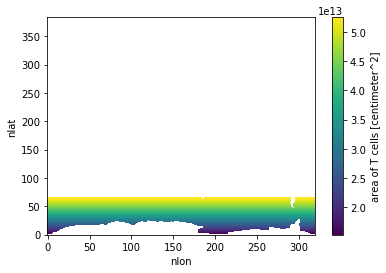

In [11]:
masked_area.plot()

In [42]:
sst_so_mean = (ds.SST * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
sst_so_mean

<xarray.DataArray (time: 1872, z_t: 1)>
dask.array<shape=(1872, 1), dtype=float64, chunksize=(1872, 1)>
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2006-01-01 00:00:00
  * z_t      (z_t) float32 500.0

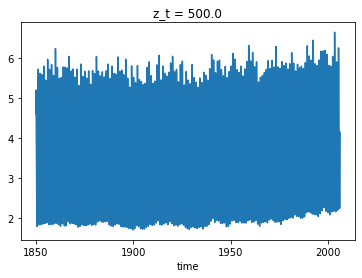

In [43]:
sst_so_mean.plot()

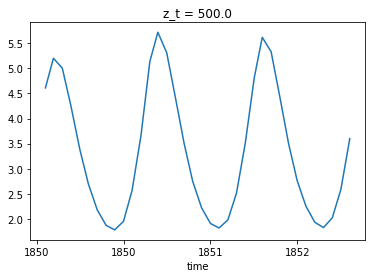

In [45]:
sst_so_mean.isel(time=slice(0, 36)).plot()

In [12]:
diatChl_so_mean = (ds.diatChl.isel(z_t_150m=0) * masked_area).sum(['nlat', 'nlon']) / masked_area.sum(['nlat', 'nlon'])
diatChl_so_mean

<xarray.DataArray (time: 1872)>
dask.array<shape=(1872,), dtype=float64, chunksize=(1872,)>
Coordinates:
  * time      (time) object 1850-02-01 00:00:00 ... 2006-01-01 00:00:00
    z_t_150m  float32 500.0

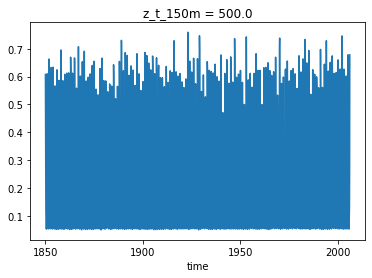

In [13]:
diatChl_so_mean.plot()